# A Zindi Competition on identifying Landslides in Hong Kong

https://zindi.africa/competitions/landslide-prevention-and-innovation-challenge/

This notebook includes some exploratory data analysis (EDA) on the training data from the landslide prevention and innovation challenge.

The data includes 9 features from areas surrounding a possible landslide site. The features are:
* Elevation (**elevation**): height above sea level
* Slope (**slope**): mean slope of the surface in degree, slopes above 30 ° are considered very steep.
* Aspect (**aspect**): exposition of the slope (north, west, south, east) in degrees with values between 0 and 360, where usually 0 means north and 90 means east.
* Planform curvature (**placurv**): see [esri](https://www.esri.com/arcgis-blog/products/product/imagery/understanding-curvature-rasters/). Planform curvature is perpendicular to the direction of the maximum slope. A positive value  indicates the surface is sidewardly convex at that cell. A negative plan indicates the surface is sidewardly concave at that cell. A value of zero indicates the surface is linear  <br> 
![planform curvature](http://downloads2.esri.com/MappingCenter2007/blog/Oct10Images/Curvature_plan.png)
* Profile curvature (**procurv**): see [esri](https://www.esri.com/arcgis-blog/products/product/imagery/understanding-curvature-rasters/). Profile curvature is parallel to the direction of the maximum slope. A negative value indicates that the surface is upwardly convex at that cell. A positive profile indicates that the surface is upwardly concave at that cell. A value of zero indicates that the surface is linear.<br>
![profile curvature](http://downloads2.esri.com/MappingCenter2007/blog/Oct10Images/Curvature_profile.png)
* Slope length and Steepness factor (**lsfactor**): see [European Soil Data Centre](https://esdac.jrc.ec.europa.eu/content/ls-factor-slope-length-and-steepness-factor-eu) LS-factor describes the effect of topography on soil erosion. The S-factor measures the effect of slope steepness, and the L-factor defines the impact of slope length.
* Topographic wetness index (**twi**): describes the water runoff characteristics depending on the topography. It depends on the slope and the watershed above.
* Geology/Surface material (**geology**): 7 different materials
* Step duration orographic intensification factor (**sdoif**): factor considering the orographic effect on rainfall. See [this paper](https://www.mdpi.com/2073-4441/12/4/1177).

The features are presented for 5x5 m² fields surrounding a possible landslide site in two rings. They are counted from 1 to 25, with 13 begin the centre. If a landslide occured, this landslide would be in field 13.

|  |  |  |  |  |
|:---:|:---:|:---:|:---:|:---:|
|1|6|11|16|21|
|2|7|12|17|22|
|3|8|**13**|18|23|
|4|9|14|19|24|
|5|10|15|20|25|

The EDA includes:
* Overview graphs for correlations of different locations of single features
* Distributions of the features depending on the label
* Correlations between features

In [1]:
# import the libraries used
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Loading the data
train = pd.read_csv('data/Train.csv')

In [3]:
# Show data
train.head()

Sample_ID  1_elevation  2_elevation  3_elevation  4_elevation  5_elevation  \
0          1          130          129          127          126          123   
1          2          161          158          155          153          151   
2          3          149          151          154          156          158   
3          4           80           78           77           75           73   
4          5          117          115          114          112          110   

   6_elevation  7_elevation  8_elevation  9_elevation  ...  17_sdoif  \
0          126          125          124          122  ...  1.281779   
1          162          159          155          153  ...  1.359639   
2          154          157          158          160  ...  1.365005   
3           80           78           77           75  ...  1.100708   
4          115          113          111          110  ...  1.284180   

   18_sdoif  19_sdoif  20_sdoif  21_sdoif  22_sdoif  23_sdoif  24_sdoif  \
0  1.281743  1.281720  1.281684  1.281811  1.281788  1.281752  1.281729   
1  1.359608  1.359587  1.359556  1.359683  1.359662  1.359631  1.359610   
2  1.365025  1.365055  1.365075  1.364937  1.364967  1.364988  1.365018   
3  1.100738  1.100759  1.100789  1.100630  1.100650  1.100680  1.100700   
4  1.284130  1.284056  1.284006  1.284125  1.284050  1.284001  1.283926   

   25_sdoif  Label  
0  1.281693      0  
1  1.359579      1  
2  1.365038      0  
3  1.100731      0  
4  1.283876      0  

[5 rows x 227 columns]

In [4]:
train.info()
# 10864 observations. 9x25 features + Sample_ID and Label

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10864 entries, 0 to 10863
Columns: 227 entries, Sample_ID to Label
dtypes: float64(175), int64(52)
memory usage: 18.8 MB


In [5]:
# Check for missing values
train.isna().sum().sum()
# No missing values

0

In [6]:
# Check for duplicates
train.duplicated().any()
# No duplicates

False

In [7]:
# Distribution of target value (0 means "no landslide", 1 means "landslide occured")
train['Label'].value_counts(normalize=True)
# unbalanced dataset has to be considered

0    0.75
1    0.25
Name: Label, dtype: float64

## Overview plots for each feature

Plots showing the spatial distribution of all features to check for volatility. Some features might change in value between the different positions of the feature for a single observation. For each feature, the same 5 positions are shown for better comparison.

In [8]:
def feature_pair_plot(feature, position, title, plotkind):
    """
    Creates a seaborn-pairplot for several positions of the same feature.
    
    feature: name of the feature-column without number and underscore
    position: list of positions of the measured fields, 13 is the central position with a possible landslide
    title: Superior title of the diagram
    plotkind: kind of plot of the comparison plots. Possible values: 'scatter', 'kde', 'hist', 'reg'
    """
    feature_cols=[]
    for i in position:
        feature_cols.append(str(i)+'_'+feature)
    plt.figure()
    sns.pairplot(train[feature_cols], kind=plotkind)
    plt.suptitle(title, y=1.01)
    plt.show()

In [9]:
# Reminder of the spatial distribution of the features
# 1 6  11 16 21
# 2 7  12 17 22
# 3 8  13 18 23
# 4 9  14 19 24
# 5 10 15 20 25

# Corner, middle and adjescent to centre positions 
# used to plot correlations between different positions of the same feature
position = [1, 17, 13, 9, 25]

### Highly correlated features

Elevation and orographic intensification factor are highly correlated between the different positions. 

For the elevation, this means, that no high cliffs or deep fractures are part of the data. 

The orographic intensification factor has something to do with the orographic influence on rainfall. Rainfall usually doesn't change in huge amounts in such a small area (25x25 m²), which can also be seen in the data. I could not find much information about this factor. See [this paper](https://www.mdpi.com/2073-4441/12/4/1177) on a study in Taiwan for more details. It includes the SDOIF.

<Figure size 640x480 with 0 Axes>

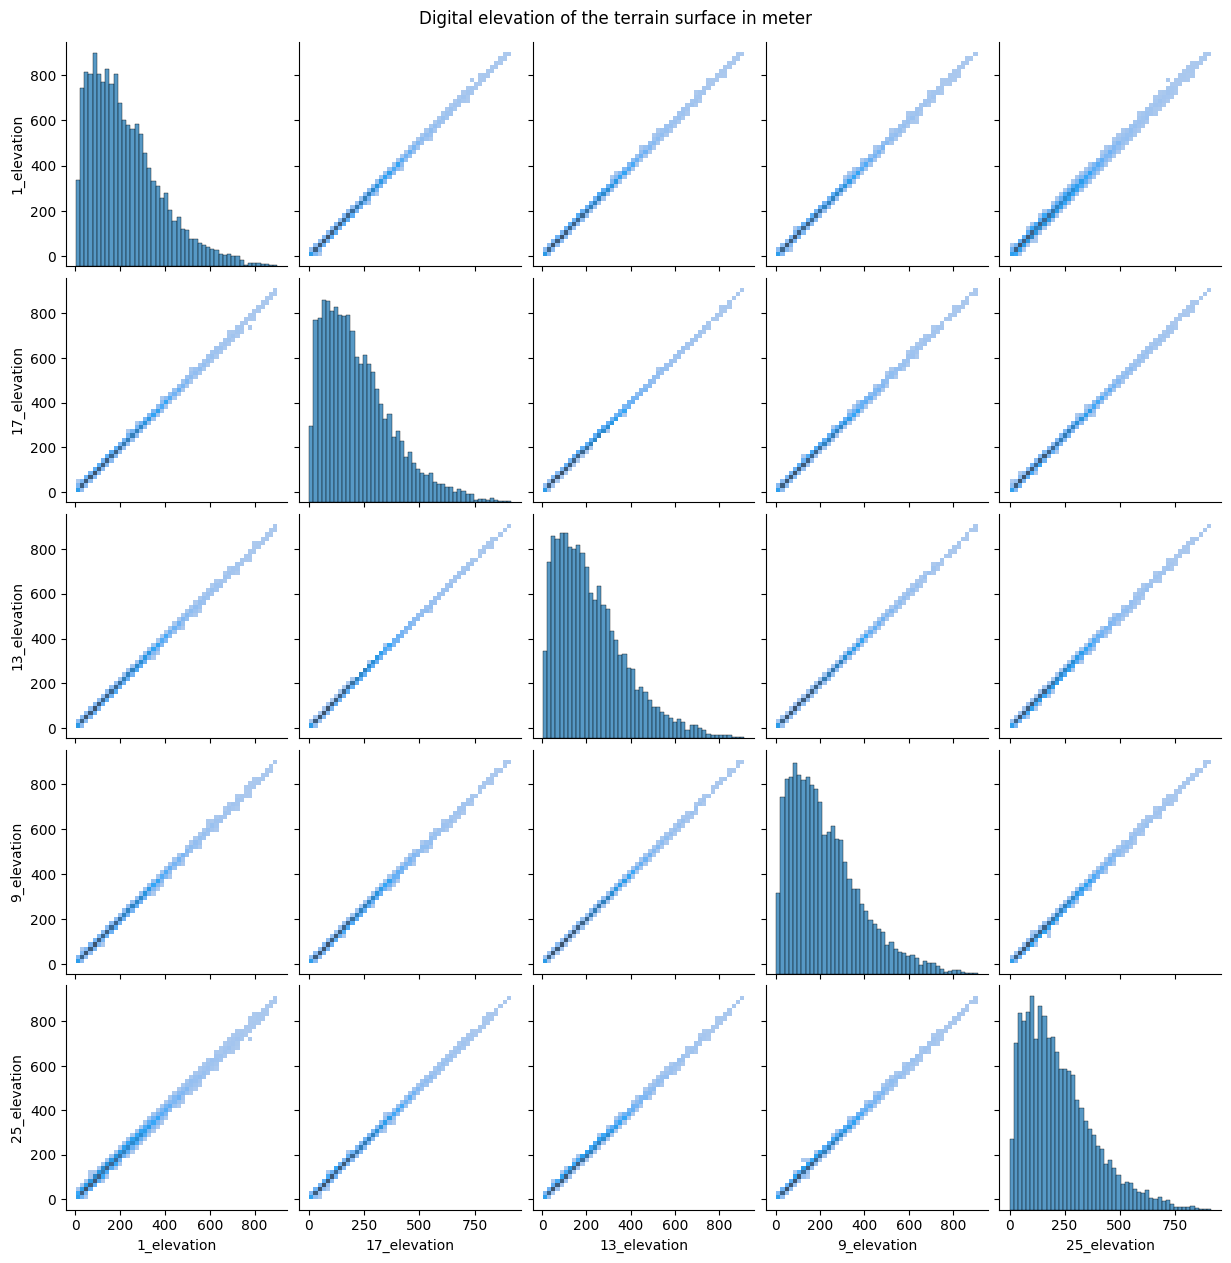

In [10]:
title='Digital elevation of the terrain surface in meter'
feature_pair_plot(feature='elevation', position=position, title=title, plotkind='hist')

# perfect correlation between different locations

<Figure size 640x480 with 0 Axes>

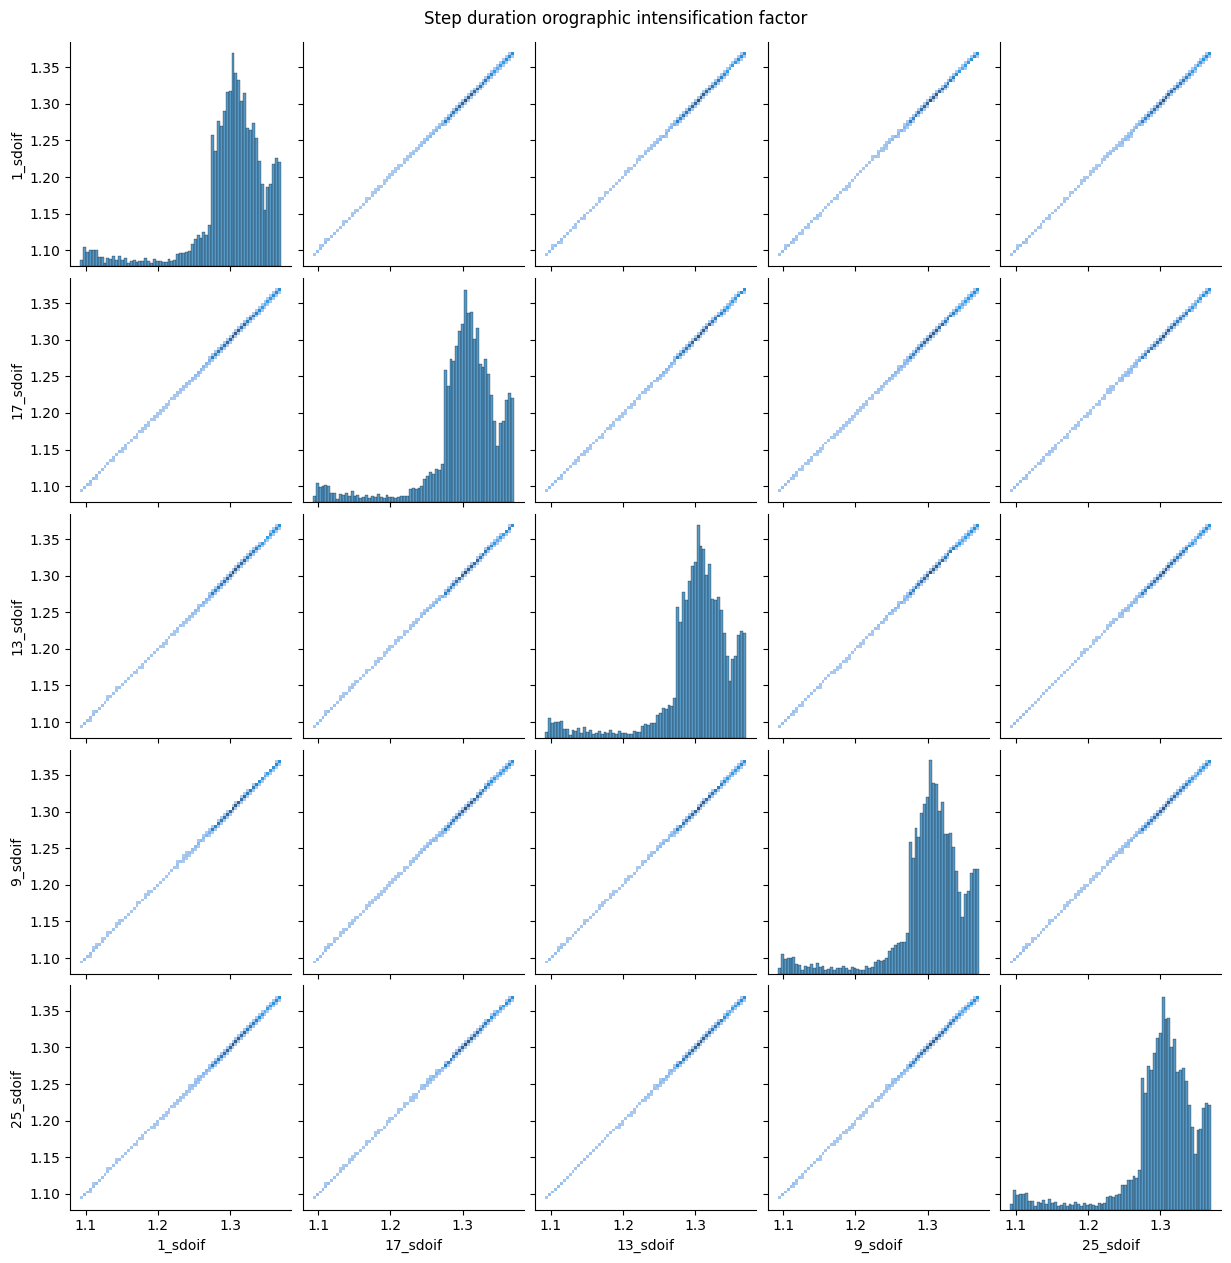

In [11]:
title='Step duration orographic intensification factor'
feature_pair_plot(feature='sdoif', position=position, title=title, plotkind='hist')

# perfect correlation all over

### Little correlation with far positions

For the features slope, aspect, lsfactor and twi the correlation reduces for positions far away from the centre. However some correlation still remains, though the values vary a lot. 

The aspect has circular values from 0 to 360. As a difference of 1 degree at 360 degrees can both mean 1° and 359° this feature has to be transformed for usage in machine learning algorithms. This can be done by sin/cosine-transformation.

The topographic wetness index is highly skewed. For small slopes, the twi gets high. This has to be taken into account when modelling with machine learning algorithms. These algorithms are usually optimised for normally distributed features. A logarithmic transformation of the data can be used for this.

<Figure size 640x480 with 0 Axes>

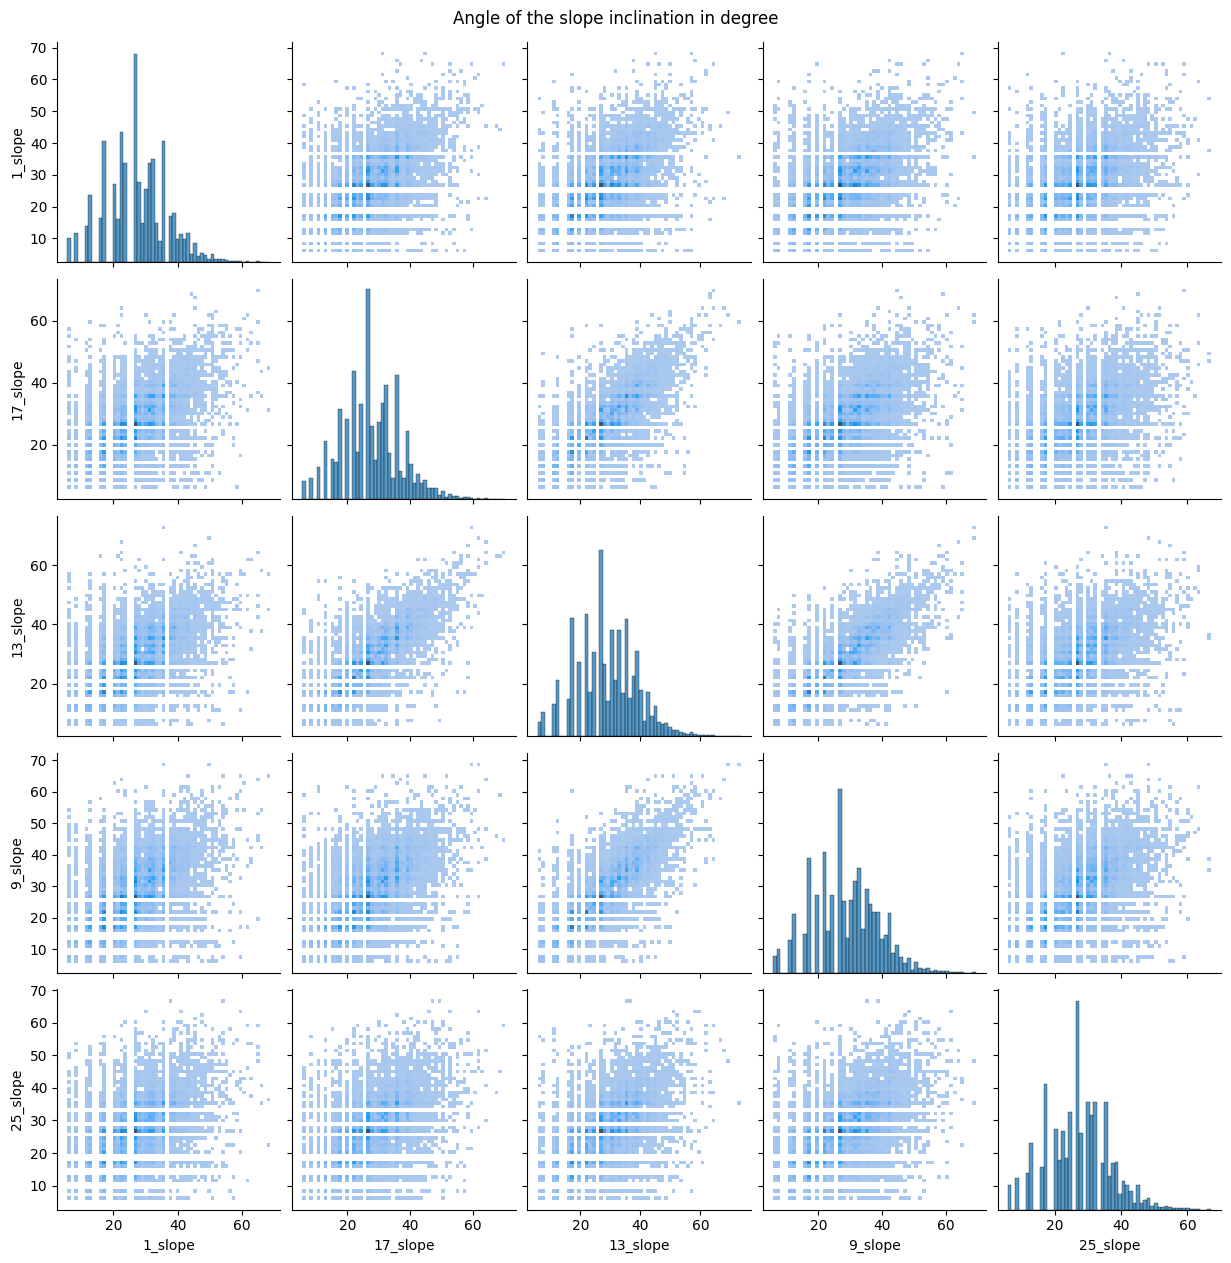

In [12]:
title='Angle of the slope inclination in degree'
feature_pair_plot(feature='slope', position=position, title=title, plotkind='hist')

# Slope varies a lot in these 25 x 25 m² samples
# Positions closer together vary less

<Figure size 640x480 with 0 Axes>

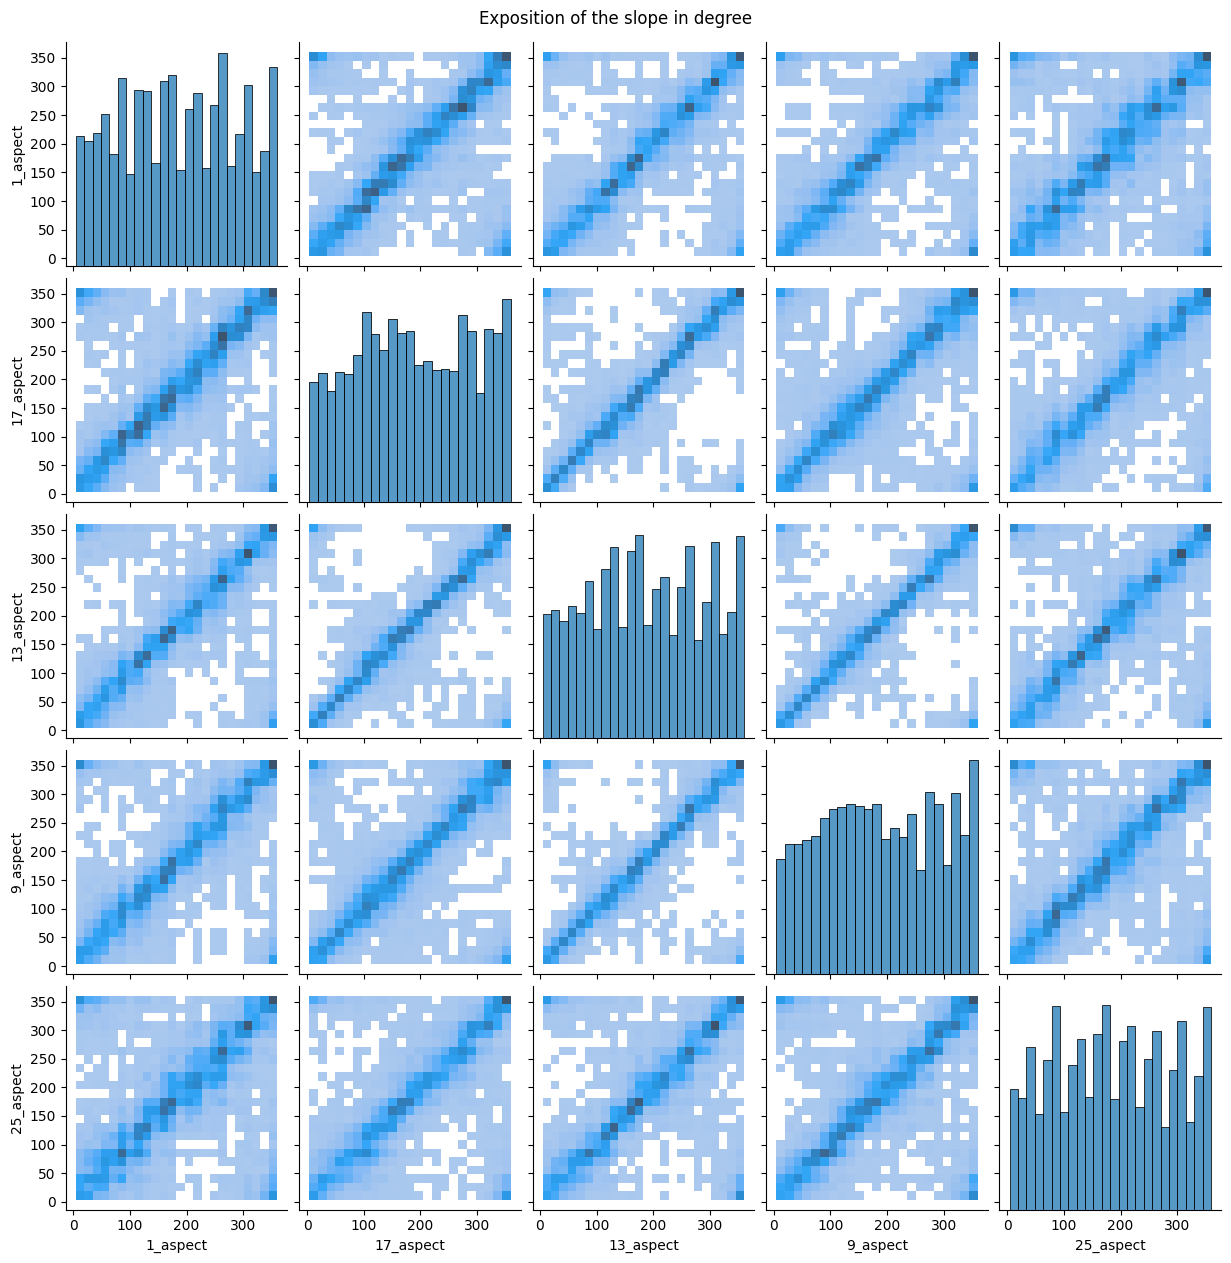

In [13]:
title='Exposition of the slope in degree'
feature_pair_plot(feature='aspect', position=position, title=title, plotkind='hist')

# High values in far edges due to circular behavior of the feature. 
# Tansformation of the feature is needed to take this into account for machine learning algorithms.
# Most aspects are close to each other though

<Figure size 640x480 with 0 Axes>

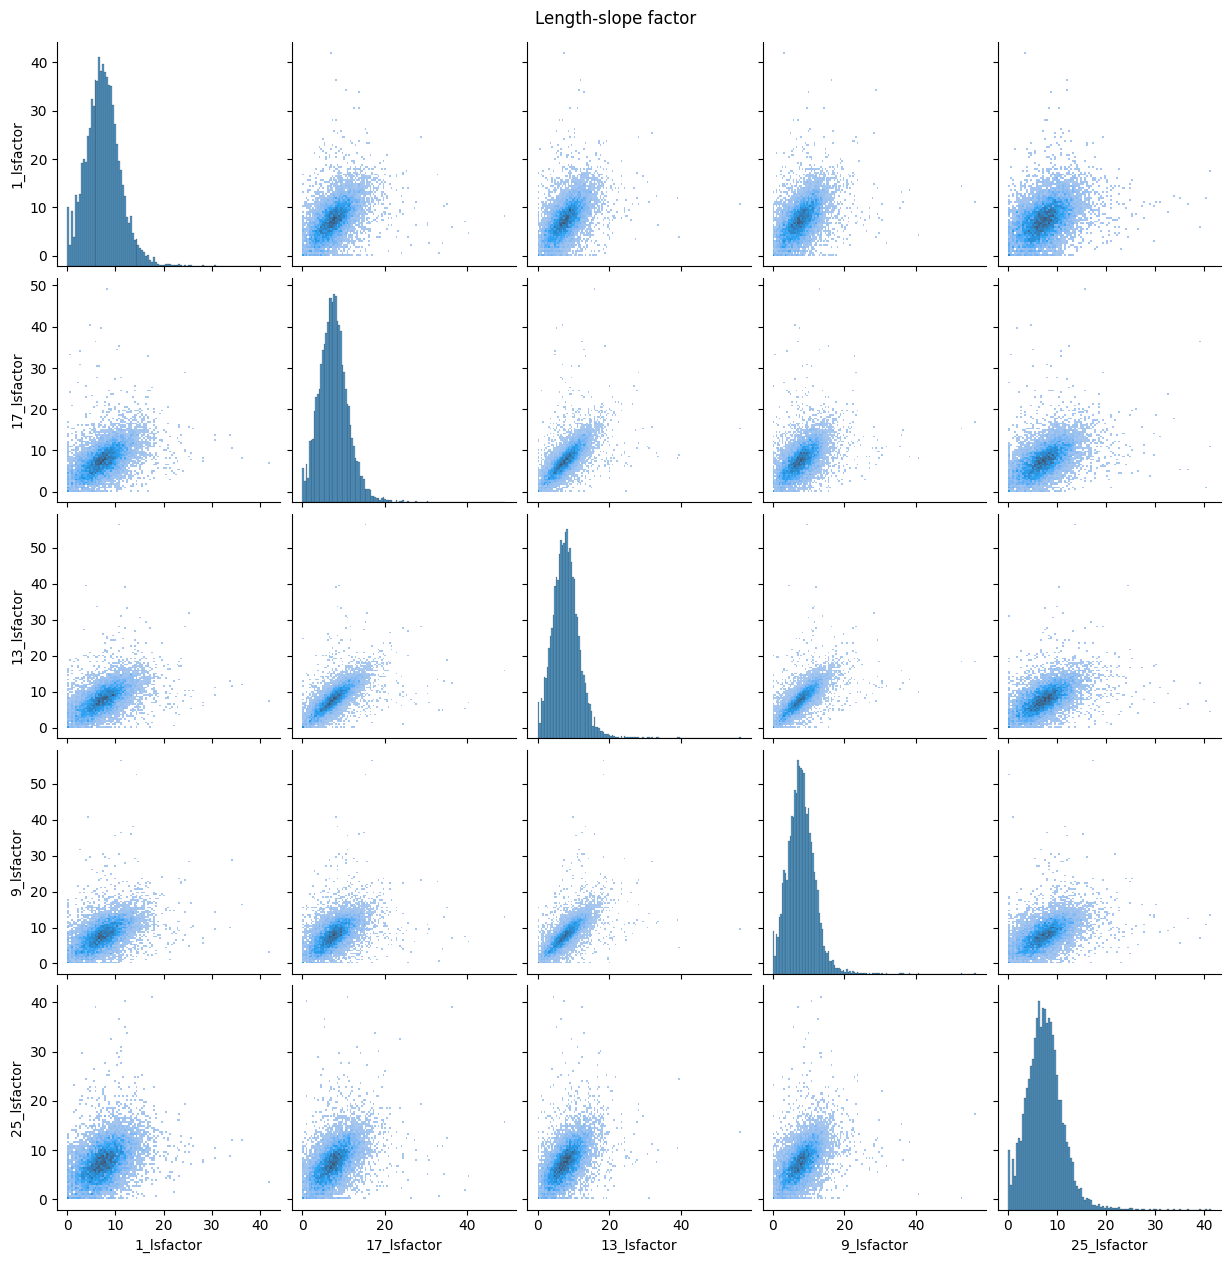

In [14]:
title='Length-slope factor'
feature_pair_plot(feature='lsfactor', position=position, title=title, plotkind='hist')

# some correlations throughout, but a lot more for close positions

<Figure size 640x480 with 0 Axes>

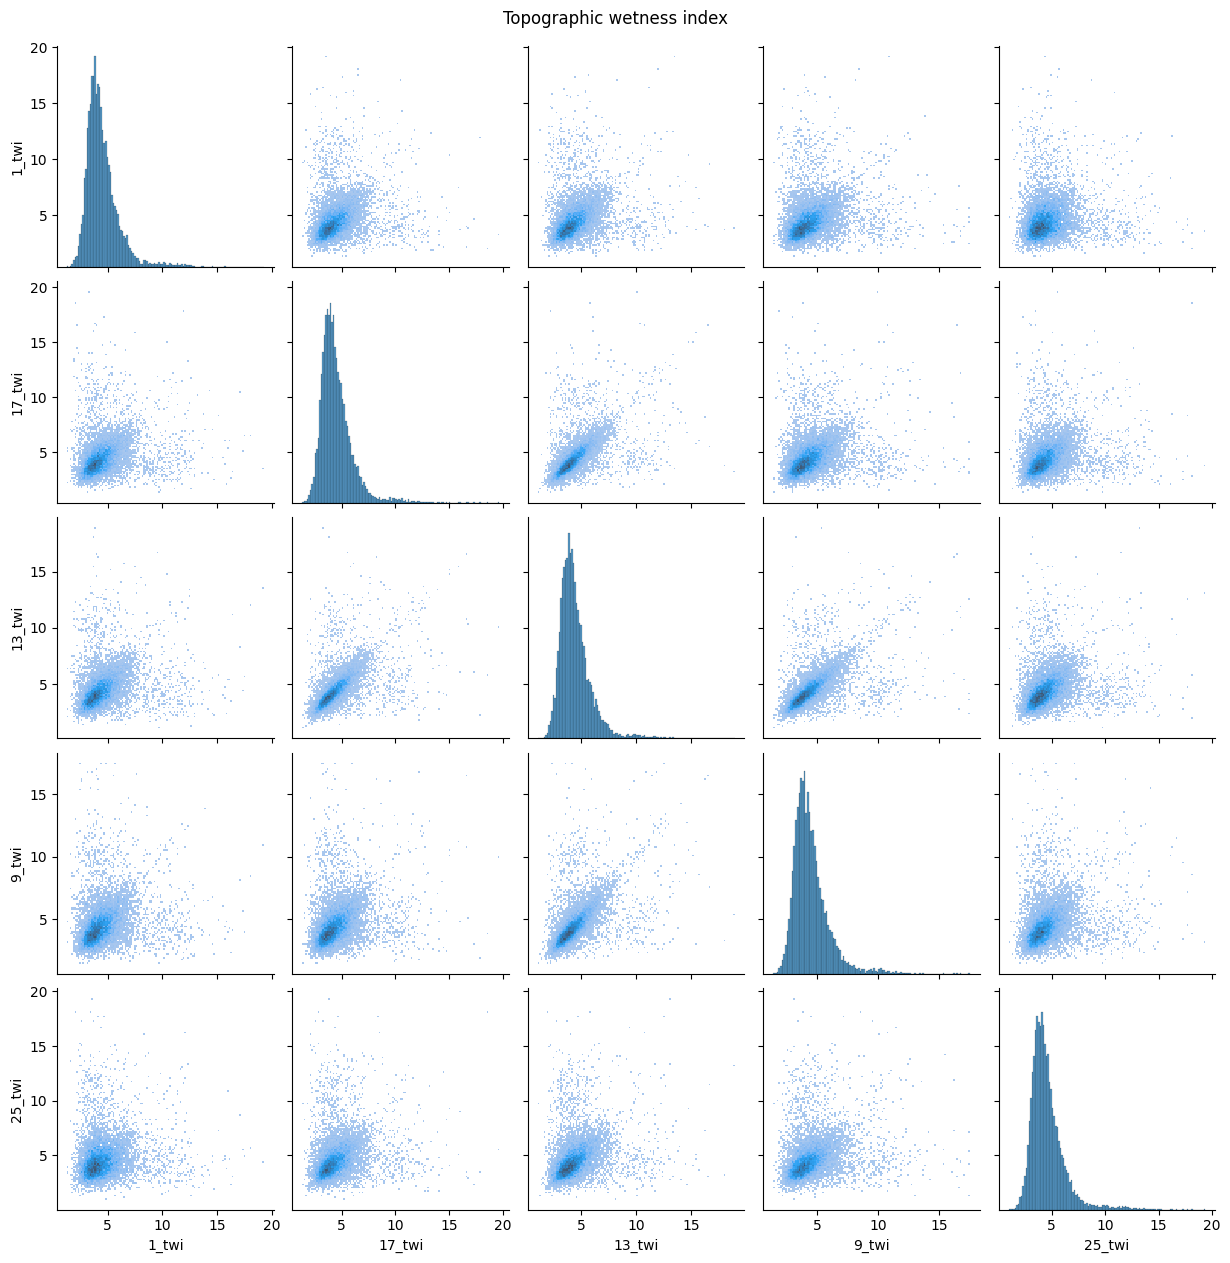

In [15]:
title='Topographic wetness index'
feature_pair_plot(feature='twi', position=position, title=title, plotkind='hist')

# Highly skewed
# Logarithmic transformation should help

### No correlation with far positions

**Planform and profile curvatures**

Distributions: 
Single positions show normal distributions. They are not skewed and centered around zero. 

Correlations: 
While positions close together show a positive correlation, this reduces very quickly as the distance increases. The farthest positions don't show a correlation at all as the scatterplot only shows a circle.

<Figure size 640x480 with 0 Axes>

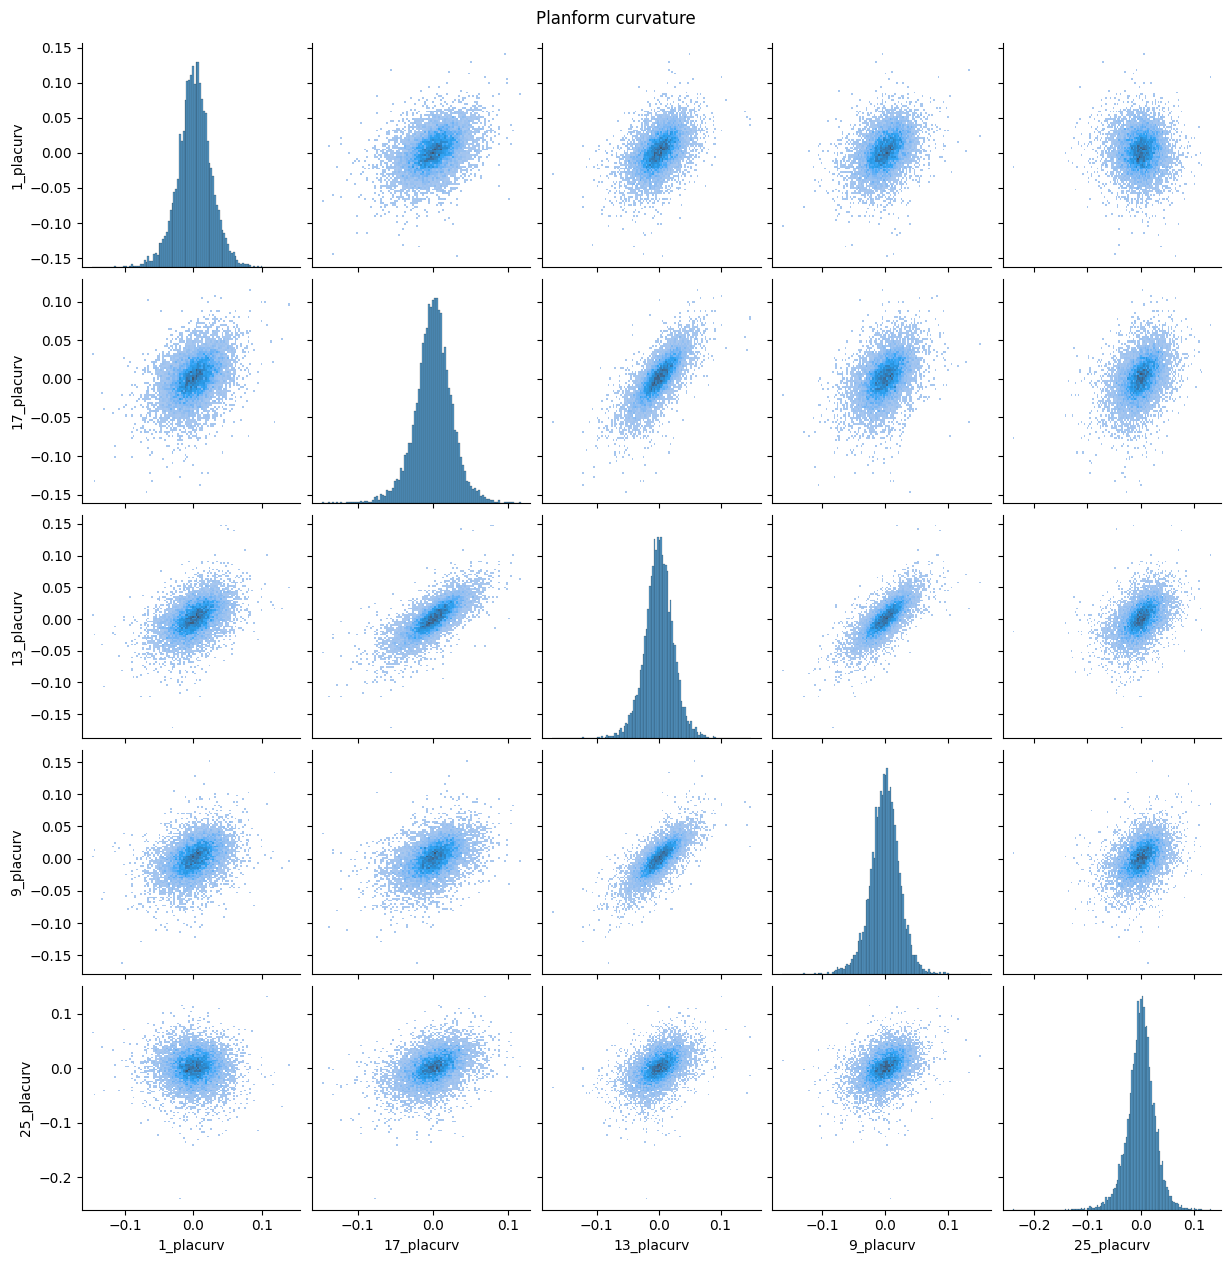

In [16]:
title='Planform curvature'
feature_pair_plot(feature='placurv', position=position, title=title, plotkind='hist')

# no correlation between far away positions
# positions closer together are still quite similar

<Figure size 640x480 with 0 Axes>

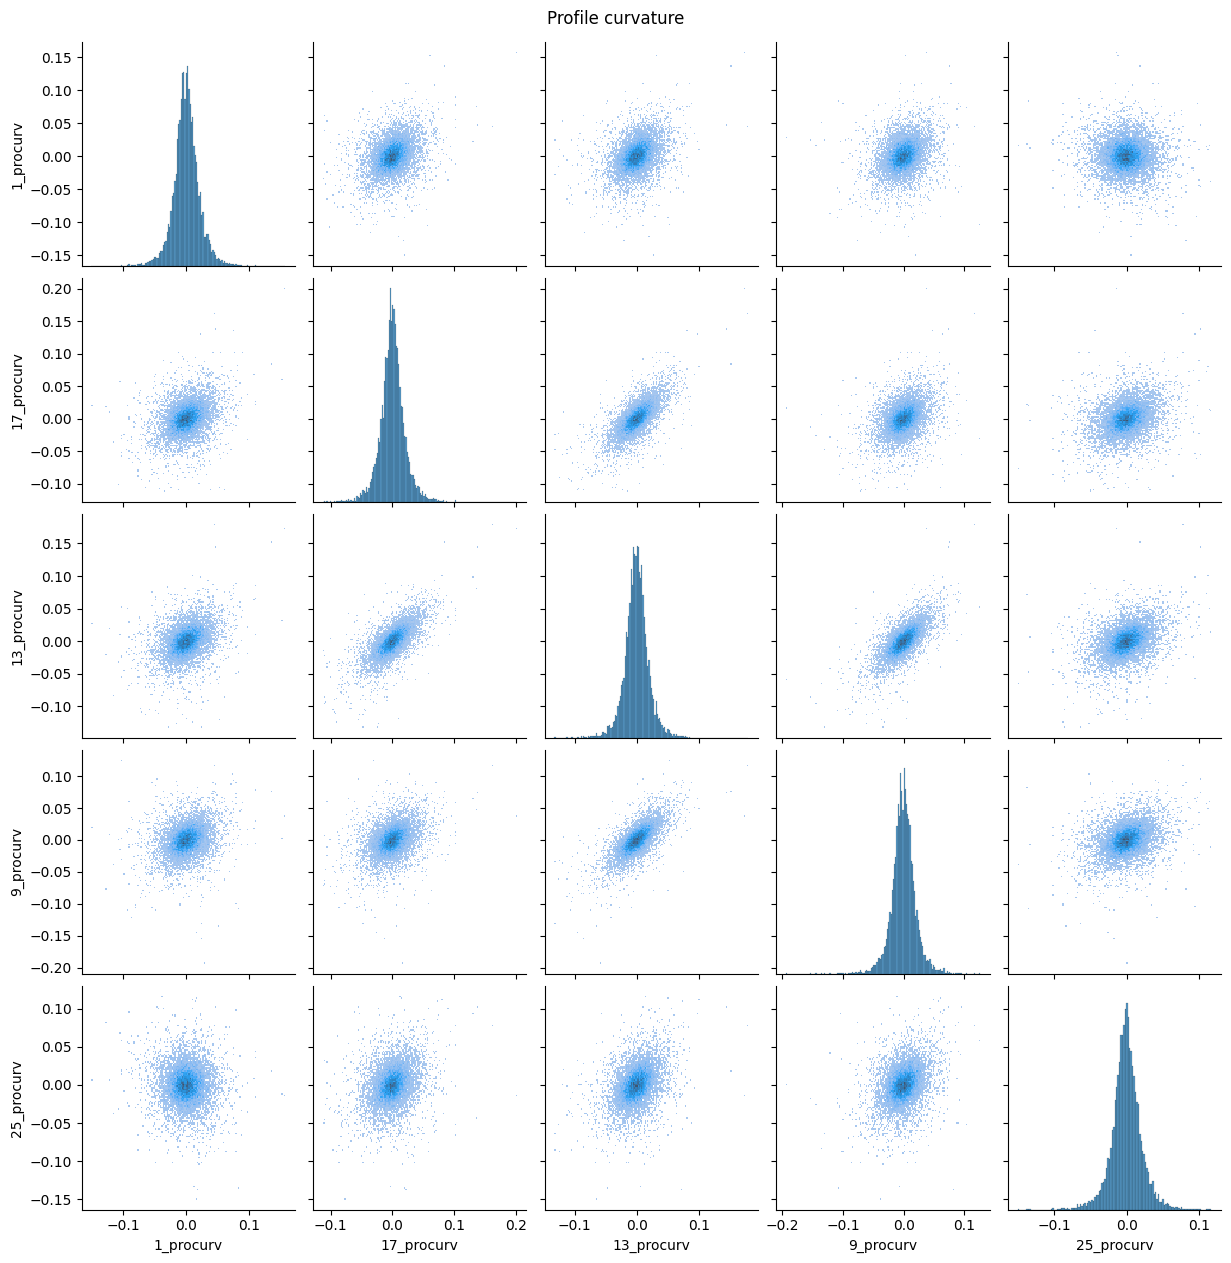

In [17]:
title='Profile curvature'
feature_pair_plot(feature='procurv', position=position, title=title, plotkind='hist')

# no correlation between far away positions
# positions closer together are still quite similar

## Geology

The surface materials are:
1. Weathered Cretaceous granitic rocks
2. Weathered Jurassic granite rocks
3. Weathered Jurassic tuff and lava
4. Weathered Cretaceous tuff and lava
5. Quaternary deposits
6. Fill
7. Weathered Jurassic sandstone, siltstone and mudstone

### Distribution

The differences in counts for each position are compared for each material.
Due to huge differences in occurences from 19 for material 6 and 6166 for material 3, only the statistical values are shown for each material. 

By far the most common surface material is jurassic tuff and lava. Fill and weathered Cretaceous tuff and lava only occur very rarely. Overall the distribution of surface materials show only very little variation.

In [18]:
geology = pd.DataFrame()
for i in range(25):
    geology[f'{i+1}_geology'] = train[f'{i+1}_geology'].value_counts()
geology.T.describe()

3            2            5           1         7          4  \
count    25.000000    25.000000    25.000000   25.000000   25.0000  25.000000   
mean   6149.880000  2043.280000  1659.640000  852.880000  116.5600  21.760000   
std      10.231976     6.484083    16.352574    4.576389    2.5671   1.011599   
min    6120.000000  2030.000000  1638.000000  844.000000  111.0000  20.000000   
25%    6145.000000  2040.000000  1649.000000  851.000000  116.0000  21.000000   
50%    6151.000000  2044.000000  1658.000000  853.000000  117.0000  22.000000   
75%    6156.000000  2046.000000  1669.000000  855.000000  118.0000  23.000000   
max    6166.000000  2056.000000  1709.000000  861.000000  120.0000  23.000000   

               6  
count  25.000000  
mean   20.000000  
std     0.645497  
min    19.000000  
25%    20.000000  
50%    20.000000  
75%    20.000000  
max    21.000000

### Correlation between central position 13 and position 1 

Mostly the material stays the same per observation. 
For material 5, sometimes the material in different positions change to material 2 or 3. Materials 2 and 3 belong to the Jurassic age, which is the oldest age mentioned here. These old rocks might therefore have been covered by the deposits from the Quaternary age.

The most common surface material is material 3 (Jurassic tuff and lava)

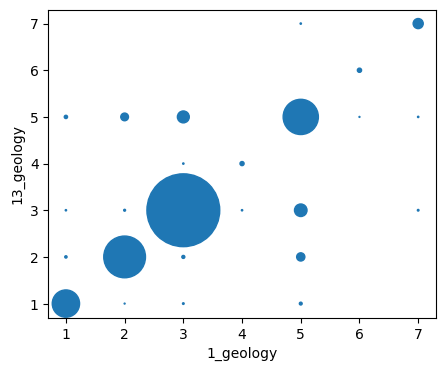

In [19]:
# inspired by https://stackoverflow.com/questions/60119971/seaborn-matplotlib-categorical-plot-markers-size-by-count-of-observations

# the categorical variables to plot
x = '1_geology'
y = '13_geology'

# Compute the counts of observations
df_counts = train.groupby([x, y]).size().reset_index()
df_counts.columns.values[df_counts.columns == 0] = 'count'

# Compute a size variable for the markers so that they have a good size regardless
# of the total count and the number of unique values in each categorical variable
scale = 200*df_counts['count'].size
size = df_counts['count']/df_counts['count'].sum()*scale

# Create matplotlib scatter plot with additional formatting
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(x, y, size, data=df_counts)
ax.set_xlabel('1_geology')
ax.set_ylabel('13_geology')
plt.show()

## Dependence of target on feature distribution

| feature | dependence |
| --- | --- |
| elevation | more landslides at higher elevation |
| slope | more landslides at higher slopes |
| aspect | more landslides between 150 and 250 ° |
| placurv | no difference |
| procurv | no difference |
| lsfactor | more landslides at higher lsfactors |
| twi | more landslides at lower twi |
| sdoif | hardly any landslides below 1.25 |
| geology | most landslides for materials 3 and 7, no landslides for material 6 fill |

Geology: Material 7 (sandstone and mudstone) has only a few observations, however the percentage of landslides is very high. These materials are usually quite weak and instable. Material 6 has no landslides, but there are only very few observations so that this can also be coincidence. Materials 1, 2 and 5 have only few landslides at high numbers of observations, therefore these seem quite safe. Material 1 and 2 are both granite rocks, which are quite hard and stable rocks.

In [20]:
# Calculating relative values of geology for better visibility
geology = train.value_counts(subset=['13_geology', 'Label'], sort=False).reset_index(name="count")
geology_sum = train.value_counts('13_geology', sort=False).reset_index(name="sum")
geology_full = geology.merge(geology_sum, on='13_geology')
geology_full['rel'] = geology_full['count']/geology_full['sum']

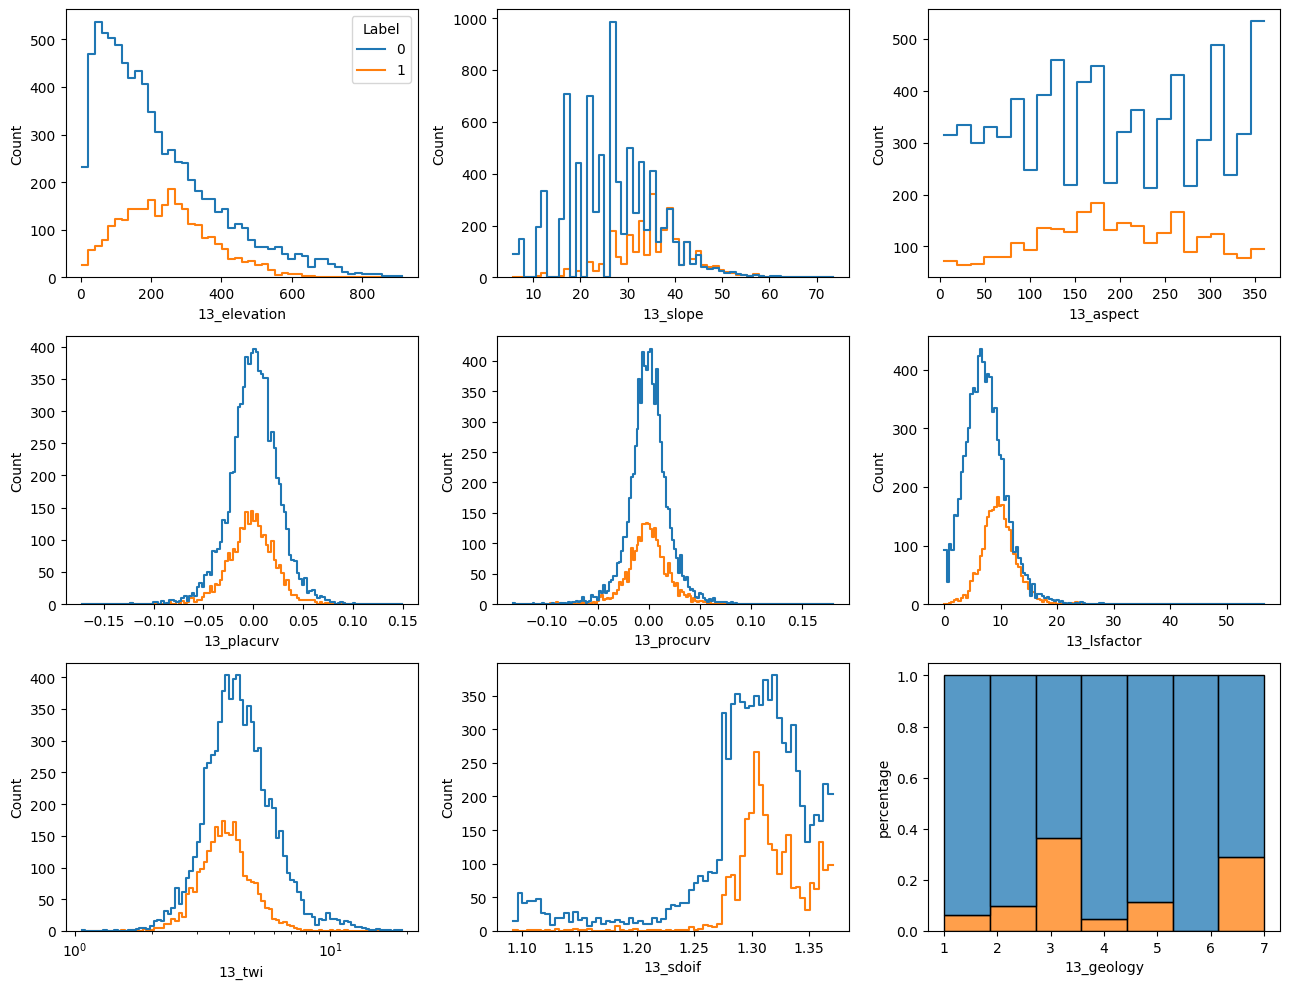

In [21]:
fig, axs = plt.subplots(3, 3, figsize = (13, 10))

sns.histplot(data=train, x="13_elevation", hue="Label", ax=axs[0,0], element="step", fill=False)
sns.histplot(train, x="13_slope", hue="Label", ax=axs[0,1], element="step", fill=False, legend=False)
sns.histplot(train, x="13_aspect", hue="Label", ax=axs[0,2], element="step", fill=False, legend=False)
sns.histplot(train, x="13_placurv", hue="Label", ax=axs[1,0], element="step", fill=False, legend=False)
sns.histplot(train, x="13_procurv", hue="Label", ax=axs[1,1], element="step", fill=False, legend=False)
sns.histplot(train, x="13_lsfactor", hue="Label", ax=axs[1,2], element="step", fill=False, legend=False)
sns.histplot(train, x="13_twi", hue="Label", ax=axs[2,0], element="step", fill=False, legend=False, log_scale=True)
sns.histplot(train, x="13_sdoif", hue="Label", ax=axs[2,1], element="step", fill=False, legend=False)
sns.histplot(geology_full, x="13_geology", hue="Label", weights='rel', bins=7, ax=axs[2,2], multiple="stack", fill=True, legend=False)

axs[2,2].set_ylabel('percentage')

fig.tight_layout()
plt.show()

## Correlations

### Scatter graphs

The scatter graphs show little correlation between most features.

Elevation and ...
* twi: higher values of twi at lower elevations.
* geography: Cretaceus tuff and lava only in very high areas, fill and sandstone, siltstone and mudstone only in low areas
* sdoif: high elevations can lead to high sdoif

Slope and ...
* aspect: interesting structure builds in the graph
* lsfactor: clear positive correlation as the calculation of the lsfactor includes the slope
* twi: higher values of twi at lower slopes.

Placurv and ...
* procurv: clear positive correlation
* twi: high values of twi only for negative placurvs

Procurv and ...
* twi: high values of twi mostly for procurvs close to 0

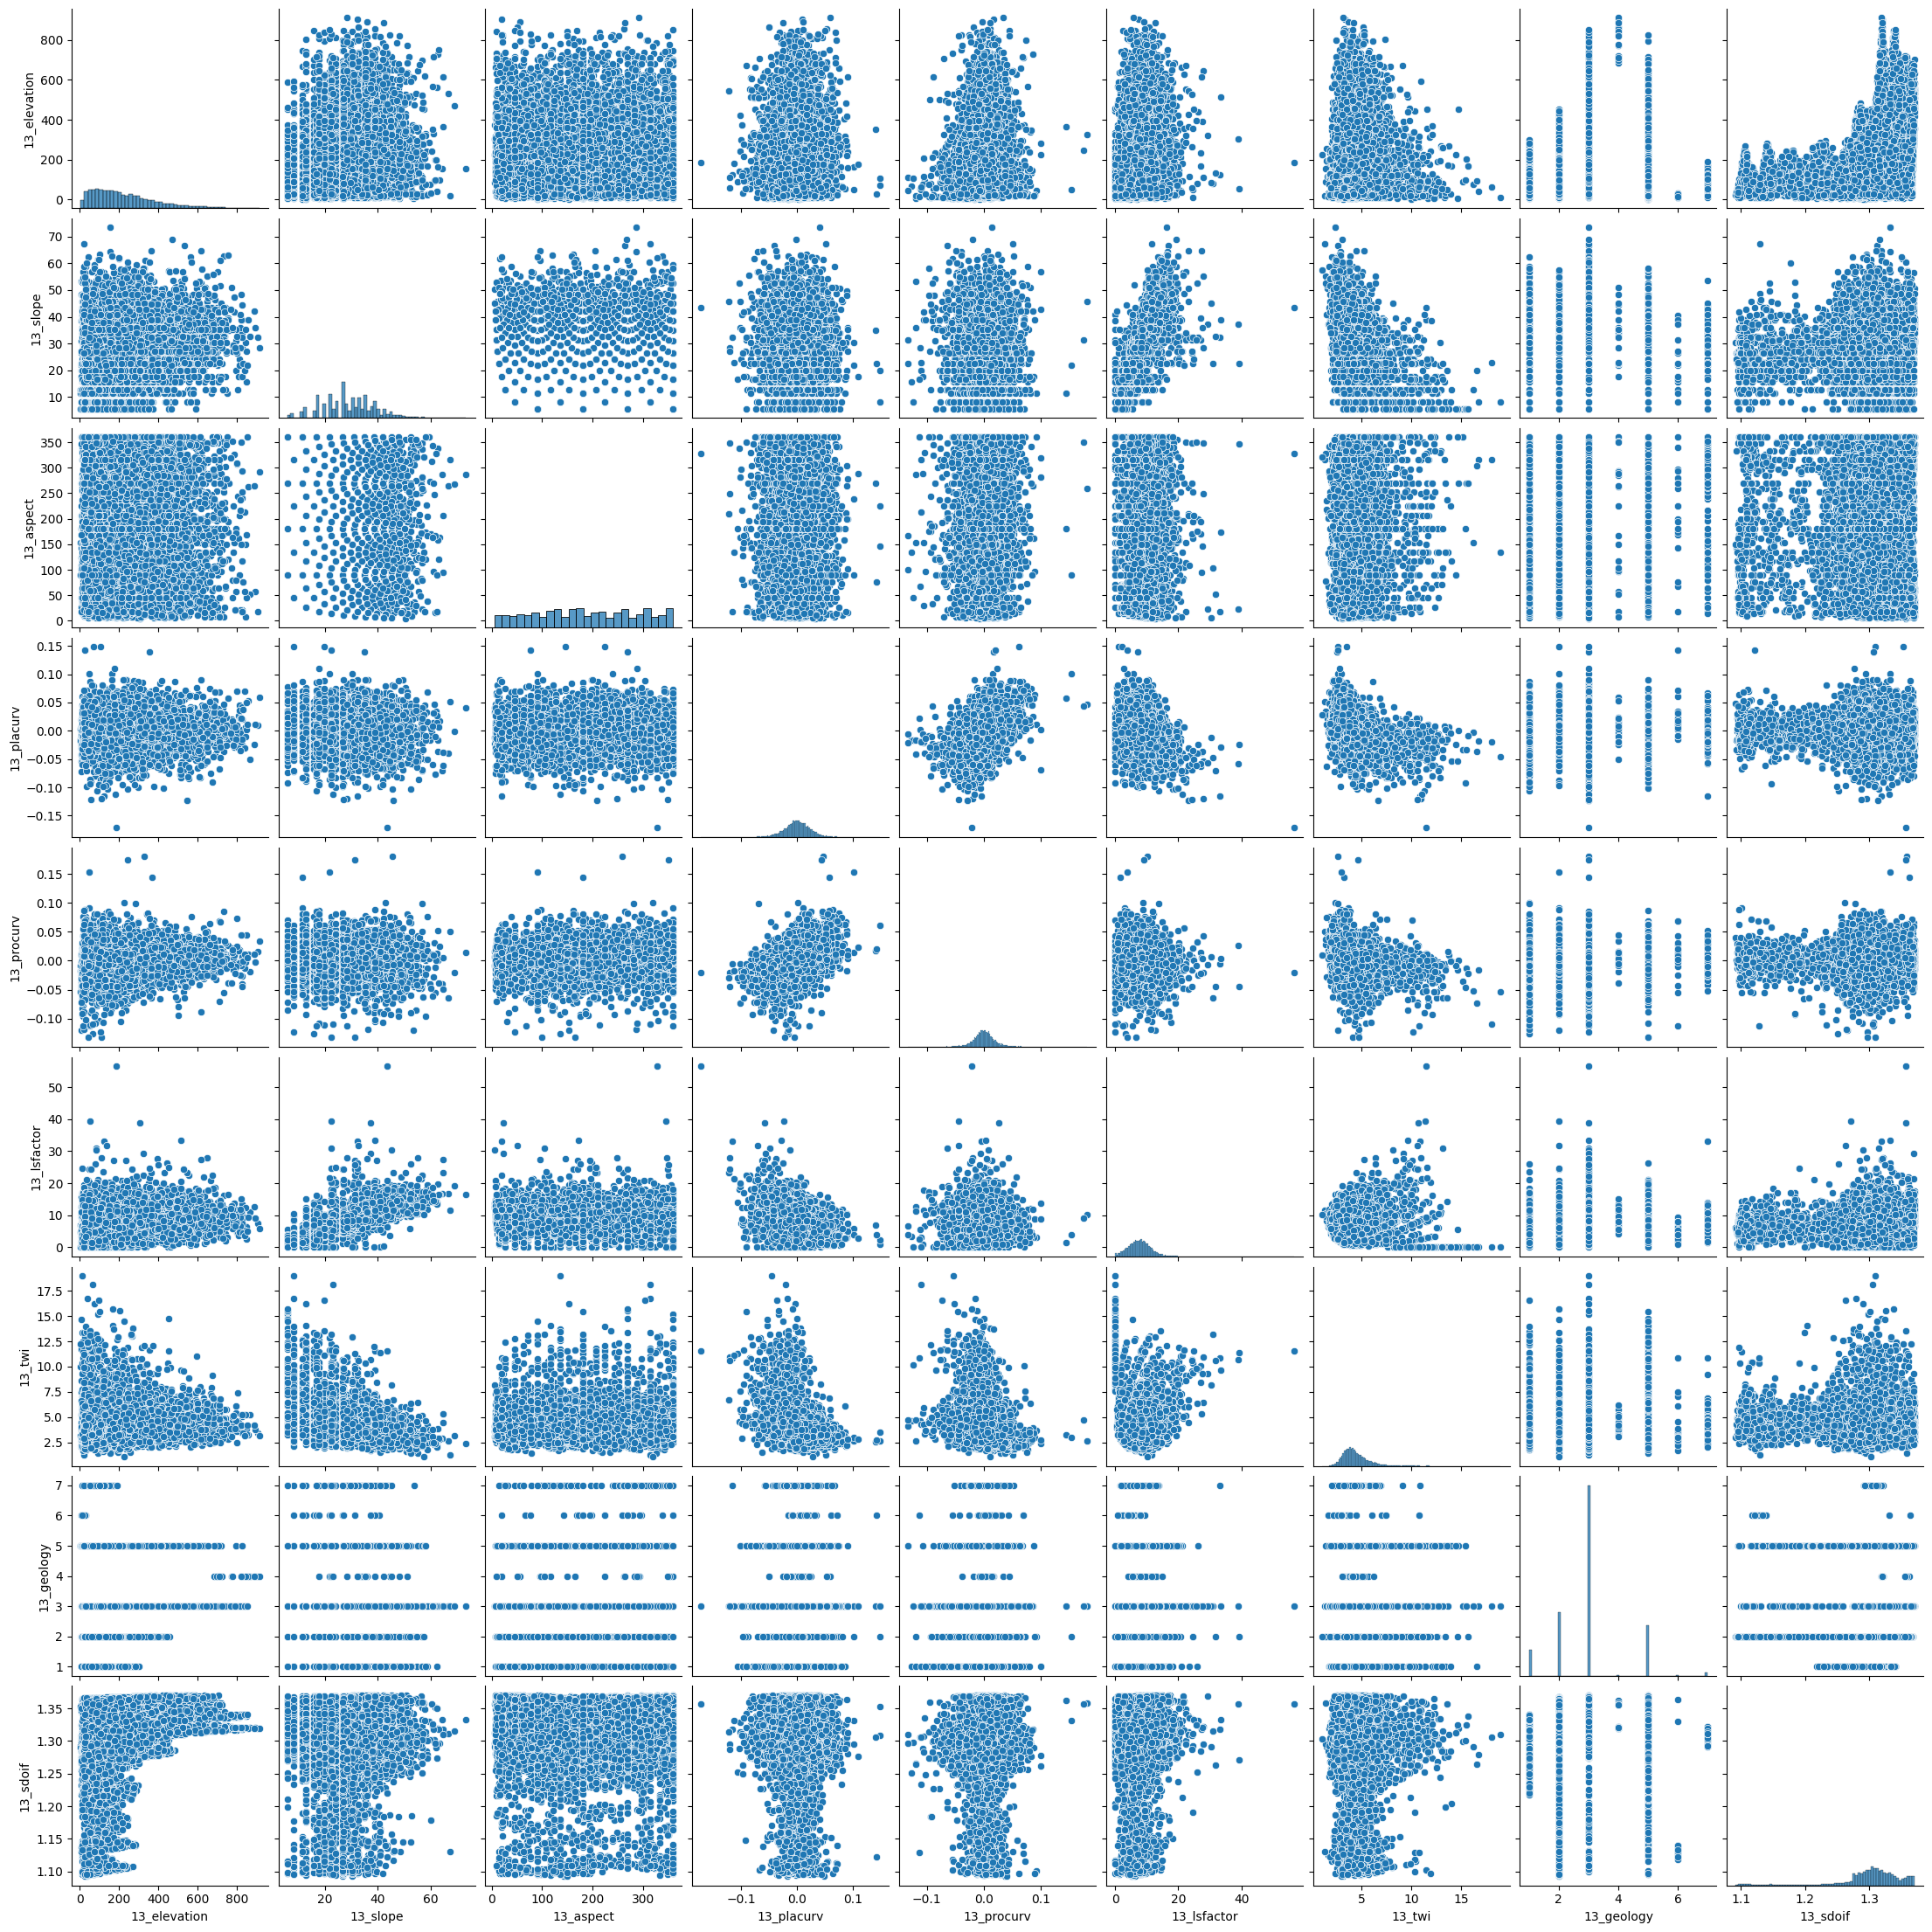

In [22]:
cols = ['13_elevation', '13_slope', '13_aspect', '13_placurv', '13_procurv', 
        '13_lsfactor', '13_twi', '13_geology', '13_sdoif']
sns.pairplot(train[cols])

### Correlation Heatmap

Highest correlation between 
* slope and lsfactor
* procurv and placurv 
* placurv and twi

Lsfactor and twi show most correlations as these are calculated features with a lot of influences.
No feature is correlated to all others.

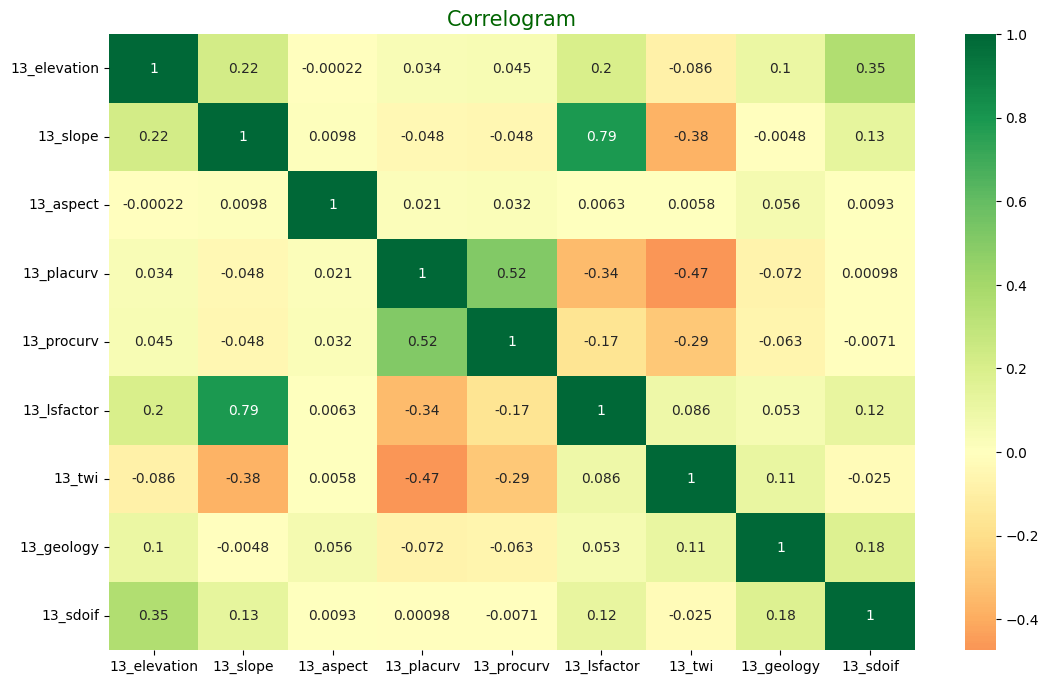

In [23]:
# Quantify correlations
corr = train[cols].corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()